# Visualizing what convnets learn

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/29<br>
**Last modified:** 2020/05/29<br>
**Description:** Displaying the visual patterns that convnet filters respond to.

## Introduction

In this example, we look into what sort of visual patterns image classification models
learn. We'll be using the `ResNet50V2` model, trained on the ImageNet dataset.

Our process is simple: we will create input images that maximize the activation of
specific filters in a target layer (picked somewhere in the middle of the model: layer
`conv3_block4_out`). Such images represent a visualization of the
pattern that the filter responds to.


## Setup


In [67]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model
# The dimensions of our input image
img_width = 500
img_height = 500
# Our target layer: we will visualize the filters from this layer.
# See `model.summary()` for list of layer names, if you want to change this.
from keras.preprocessing import image
layer_name = "conv2d_43"


## Build a feature extraction model


In [68]:
# Build a ResNet50V2 model loaded with pre-trained ImageNet weights
model = load_model('/content/drive/MyDrive/Kaggle/3_class_scratch_softmax_acc95.h5')
# Set up a model that returns the activation values for our target layer
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)


In [42]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 498, 498, 32)      320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 498, 498, 32)      128       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 123, 123, 32)      1056      
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 61, 61, 32)       

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in
our target layer. To avoid border effects, we exclude border pixels.


In [69]:

def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index]
    return tf.reduce_mean(filter_activation)



Our gradient ascent function simply computes the gradients of the loss above
with regard to the input image, and update the update image so as to move it
towards a state that will activate the target filter more strongly.


In [71]:

@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads
    return loss, img



## Set up the end-to-end filter visualization loop

Our process is as follow:

- Start from a random image that is close to "all gray" (i.e. visually netural)
- Repeatedly apply the gradient ascent step function defined above
- Convert the resulting input image back to a displayable form, by normalizing it,
center-cropping it, and restricting it to the [0, 255] range.


In [78]:
import cv2
def initialize_image():
    # We start from a gray image with some random noise
    img = cv2.imread('/content/drive/MyDrive/Covid git/Data/val/Viral Pneumonia/Viral Pneumonia (1020).png',0)
    img = cv2.resize(img, (500, 500))
    img=image.img_to_array(img)
    img=np.expand_dims(img, axis=0)
    # ResNet50V2 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25


def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 30
    learning_rate = 20
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img


def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img



Let's try it out with filter 0 in the target layer:


In [79]:
from IPython.display import Image, display

loss, img = visualize_filter(24)
keras.preprocessing.image.save_img("0.png", img)


This is what an input that maximizes the response of filter 0 in the target layer would
look like:


In [ ]:
display(Image("0.png"))


## Visualize the first 64 filters in the target layer

Now, let's make a 8x8 grid of the first 64 filters
in the target layer to get of feel for the range
of different visual patterns that the model has learned.


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8


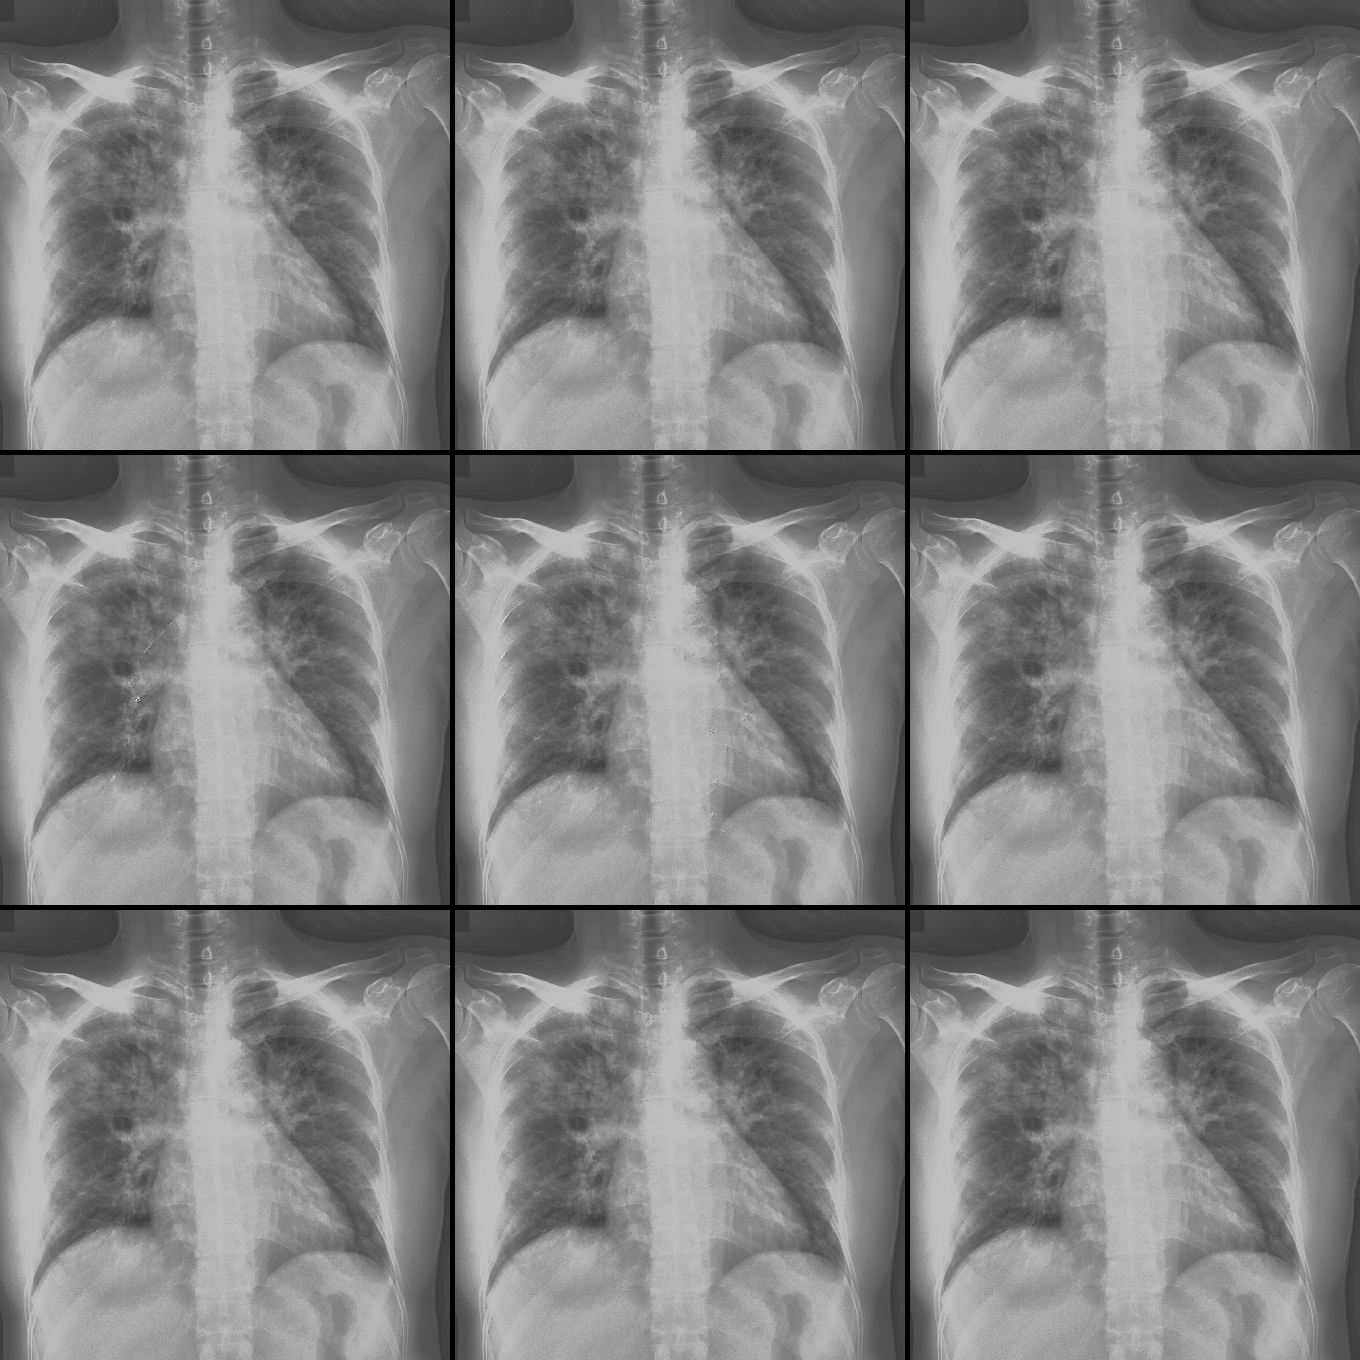

In [57]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(9):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 3
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("stiched_filters.png", stitched_filters)

from IPython.display import Image, display

display(Image("stiched_filters.png"))


Image classification models see the world by decomposing their inputs over a "vector
basis" of texture filters such as these.

See also
[this old blog post](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
for analysis and interpretation.
